In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

## Dataset info

### Original dataset

- No. instances: 253680
- Class balances
    - Label 0 — 218334 (86%)
    - Label 1 — 35346 (14%)
- No. features: 21 features
    - Real valued features, 1
        - BMI — 84 distinct values
    - Volatile features, 3
        - Age — 13 distinct values
        - Mental health — 31 distinct values
        - Physical health — 31 distinct values
    - Categorical features, 17

### Processed dataset

- Procedure
    - Removed 5 features: Fruits, Veggies, Sex, CholCheck, AnyHealthcare
    - Scale real valued + volatile features (4 in total)
    - Covert categorical features to one hot encodings
    - Undersample with NearMiss
- No. instances: 70692
    - Class balance: 35346 - 35346
- No. features: 34 features
    - Real valued features, 4
    - Binary features: 28
- Train data: 49484 (24742 - 24742)
- Hold out test: 21208 (30%) (10604 - 10604)

In [2]:
# We load from pre-processed data

train_npz = np.load("/data/public/cdc/train_cdc_undersampled.npz", "r")
train_X = train_npz["X"]
train_y = train_npz["y"]

test_npz = np.load("/data/public/cdc/hold_out_test_cdc_undersampled.npz", "r")
hold_out_test_X = test_npz["X"]
hold_out_test_y = test_npz["y"]

print("Train shape: ", train_X.shape)
print("Test shape: ", hold_out_test_X.shape)


Train shape:  (49484, 32)
Test shape:  (21208, 32)


In [3]:
train_y.mean(), hold_out_test_y.mean()

(0.5, 0.5)

### Common code

In [4]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [5]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [6]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_mcc = []

    hold_out_accuracy = []
    hold_out_precision = []
    hold_out_recall = []
    hold_out_f1 = []
    hold_out_mcc = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        prec = precision_score(train_y[test_index], y_pred, zero_division=0)
        rec = recall_score(train_y[test_index], y_pred)
        f1 = f1_score(train_y[test_index], y_pred)
        mcc = matthews_corrcoef(train_y[test_index], y_pred)
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
        fold_mcc.append(mcc)
        print(
            f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        prec = precision_score(
            hold_out_test_y, y_hold_out_pred, zero_division=0
        )
        rec = recall_score(hold_out_test_y, y_hold_out_pred)
        f1 = f1_score(hold_out_test_y, y_hold_out_pred)
        mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        hold_out_precision.append(prec)
        hold_out_recall.append(rec)
        hold_out_f1.append(f1)
        hold_out_mcc.append(mcc)
        print(
            f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
    print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
    print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
    print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
    print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

Fold 0: Accuracy=0.8848, Precision=0.9302, Recall=0.8321, F1=0.8784, MCC=0.7739
Hold-out Test: Accuracy=0.8808, Precision=0.9314, Recall=0.8221, F1=0.8734, MCC=0.7669
Fold 1: Accuracy=0.8836, Precision=0.9262, Recall=0.8337, F1=0.8775, MCC=0.7711
Hold-out Test: Accuracy=0.8808, Precision=0.9309, Recall=0.8226, F1=0.8734, MCC=0.7667
Fold 2: Accuracy=0.8873, Precision=0.9325, Recall=0.8351, F1=0.8811, MCC=0.7789
Hold-out Test: Accuracy=0.8803, Precision=0.9309, Recall=0.8216, F1=0.8728, MCC=0.7659
Fold 3: Accuracy=0.8930, Precision=0.9343, Recall=0.8454, F1=0.8876, MCC=0.7896
Hold-out Test: Accuracy=0.8809, Precision=0.9312, Recall=0.8225, F1=0.8735, MCC=0.7670
Fold 4: Accuracy=0.8846, Precision=0.9357, Recall=0.8260, F1=0.8774, MCC=0.7745
Hold-out Test: Accuracy=0.8812, Precision=0.9334, Recall=0.8209, F1=0.8736, MCC=0.7680

Cross-Validation Results:
Mean Accuracy: 0.887 ± 0.002
Mean Precision: 0.932 ± 0.002
Mean Recall: 0.834 ± 0.

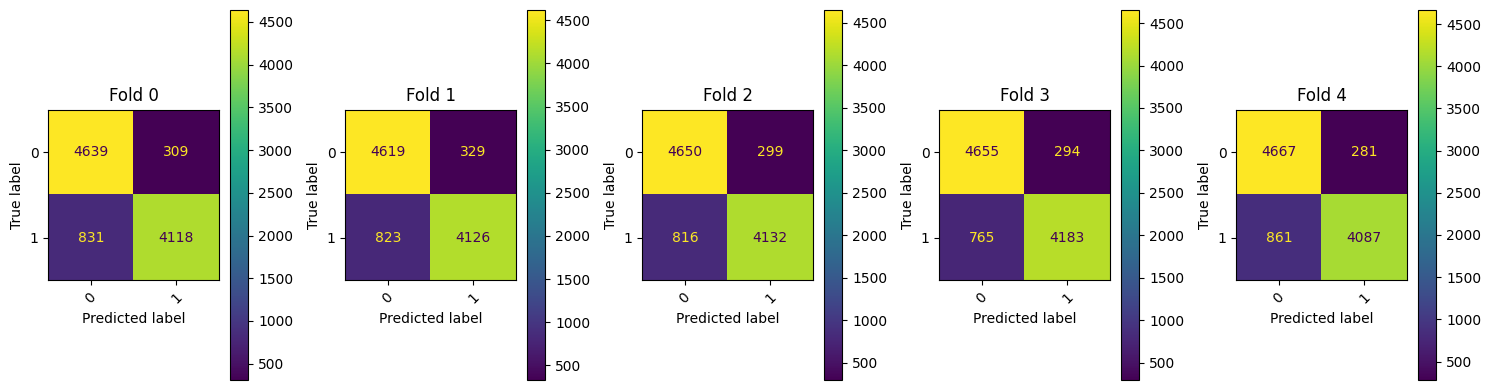

In [7]:
model = LogisticRegression(solver="liblinear")
binary_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

Fold 0: Accuracy=0.8922, Precision=0.9176, Recall=0.8618, F1=0.8888, MCC=0.7858
Hold-out Test: Accuracy=0.8945, Precision=0.9236, Recall=0.8601, F1=0.8907, MCC=0.7908
Fold 1: Accuracy=0.8960, Precision=0.9224, Recall=0.8648, F1=0.8927, MCC=0.7936
Hold-out Test: Accuracy=0.8927, Precision=0.9202, Recall=0.8600, F1=0.8891, MCC=0.7871
Fold 2: Accuracy=0.8956, Precision=0.9202, Recall=0.8664, F1=0.8925, MCC=0.7926
Hold-out Test: Accuracy=0.8921, Precision=0.9195, Recall=0.8595, F1=0.8885, MCC=0.7859
Fold 3: Accuracy=0.8993, Precision=0.9174, Recall=0.8775, F1=0.8970, MCC=0.7993
Hold-out Test: Accuracy=0.8936, Precision=0.9186, Recall=0.8636, F1=0.8903, MCC=0.7886
Fold 4: Accuracy=0.8953, Precision=0.9245, Recall=0.8610, F1=0.8916, MCC=0.7925
Hold-out Test: Accuracy=0.8927, Precision=0.9215, Recall=0.8584, F1=0.8889, MCC=0.7872

Cross-Validation Results:
Mean Accuracy: 0.896 ± 0.001
Mean Precision: 0.920 ± 0.001
Mean Recall: 0.866 ± 0.003
Me

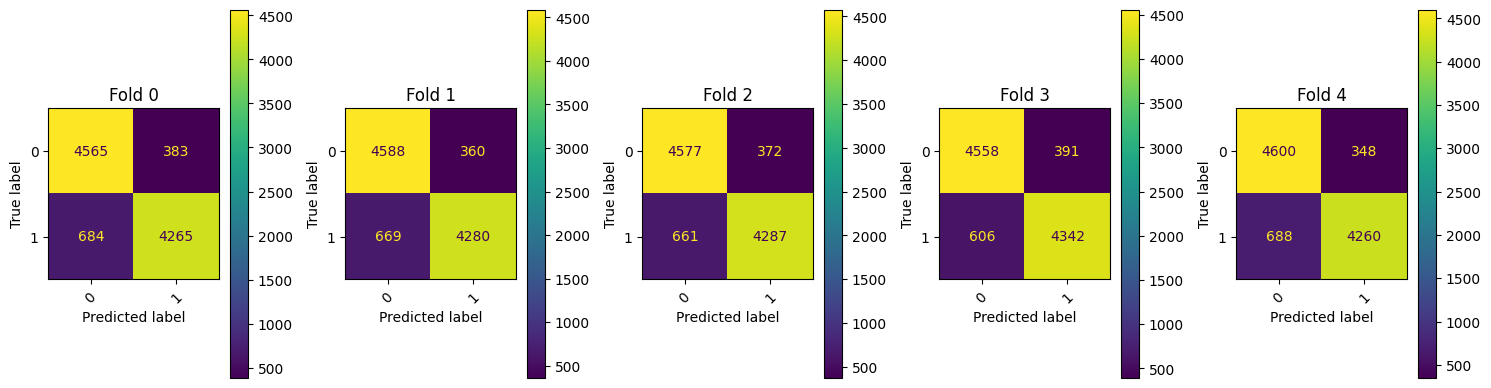

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
binary_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

Fold 0: Accuracy=0.9054, Precision=0.9641, Recall=0.8422, F1=0.8991, MCC=0.8174
Hold-out Test: Accuracy=0.9017, Precision=0.9661, Recall=0.8327, F1=0.8944, MCC=0.8112
Fold 1: Accuracy=0.9016, Precision=0.9564, Recall=0.8416, F1=0.8953, MCC=0.8090
Hold-out Test: Accuracy=0.9014, Precision=0.9655, Recall=0.8324, F1=0.8941, MCC=0.8105
Fold 2: Accuracy=0.9069, Precision=0.9673, Recall=0.8424, F1=0.9005, MCC=0.8208
Hold-out Test: Accuracy=0.9004, Precision=0.9652, Recall=0.8308, F1=0.8930, MCC=0.8087
Fold 3: Accuracy=0.9116, Precision=0.9646, Recall=0.8545, F1=0.9062, MCC=0.8286
Hold-out Test: Accuracy=0.9009, Precision=0.9619, Recall=0.8349, F1=0.8939, MCC=0.8089
Fold 4: Accuracy=0.9061, Precision=0.9668, Recall=0.8411, F1=0.8996, MCC=0.8192
Hold-out Test: Accuracy=0.9011, Precision=0.9639, Recall=0.8335, F1=0.8939, MCC=0.8097

Cross-Validation Results:
Mean Accuracy: 0.906 ± 0.001
Mean Precision: 0.964 ± 0.002
Mean Recall: 0.844 ± 0.002
Mean F1 Scor

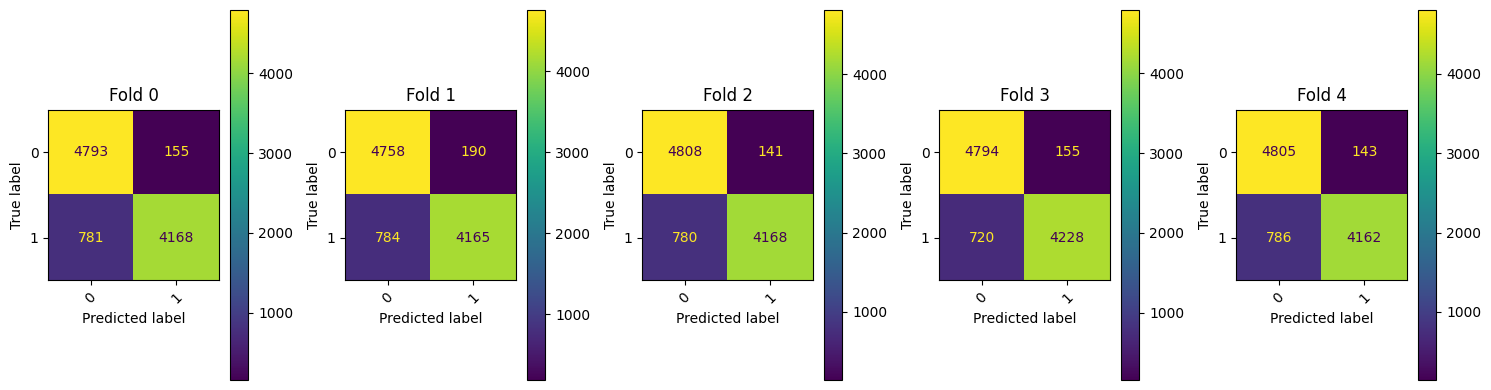

In [9]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
binary_classification(model, "SVM")

## Decision tree

In [10]:
# Function to calculate the average depth of the decision tree
def average_tree_depth(tree):
    def _recursive_depth(node, current_depth, depths):
        if (
            tree.children_left[node] == tree.children_right[node]
        ):  # It's a leaf node
            depths.append(current_depth)
            return
        _recursive_depth(tree.children_left[node], current_depth + 1, depths)
        _recursive_depth(tree.children_right[node], current_depth + 1, depths)

    depths = []
    _recursive_depth(0, 0, depths)  # Start from the root node (index 0)
    return sum(depths) / len(depths)


# Function to count the number of branches (internal nodes)
def count_branches(tree):
    n_nodes = tree.node_count  # Total number of nodes in the tree
    n_leaves = tree.n_leaves  # Total number of leaf nodes
    n_branches = n_nodes - n_leaves  # Number of internal nodes (branches)
    return n_branches

Decision tree with 5-fold cross-validation

Fold 0: Accuracy=0.8648, Precision=0.8685, Recall=0.8598, F1=0.8641, MCC=0.7297
Hold-out Test: Accuracy=0.8668, Precision=0.8715, Recall=0.8605, F1=0.8660, MCC=0.7336
Fold 1: Accuracy=0.8691, Precision=0.8753, Recall=0.8608, F1=0.8680, MCC=0.7382
Hold-out Test: Accuracy=0.8656, Precision=0.8721, Recall=0.8568, F1=0.8644, MCC=0.7313
Fold 2: Accuracy=0.8834, Precision=0.9047, Recall=0.8571, F1=0.8802, MCC=0.7679
Hold-out Test: Accuracy=0.8791, Precision=0.9034, Recall=0.8488, F1=0.8753, MCC=0.7595
Fold 3: Accuracy=0.8823, Precision=0.9051, Recall=0.8541, F1=0.8789, MCC=0.7658
Hold-out Test: Accuracy=0.8776, Precision=0.9044, Recall=0.8445, F1=0.8734, MCC=0.7568
Fold 4: Accuracy=0.8857, Precision=0.9114, Recall=0.8545, F1=0.8820, MCC=0.7729
Hold-out Test: Accuracy=0.8797, Precision=0.9064, Recall=0.8468, F1=0.8756, MCC=0.7610

Cross-Validation Results:
Mean Accuracy: 0.877 ± 0.004
Mean Precision: 0.893 ± 0.008
Mean Recall: 0.857 ± 0.001
Mean F1 

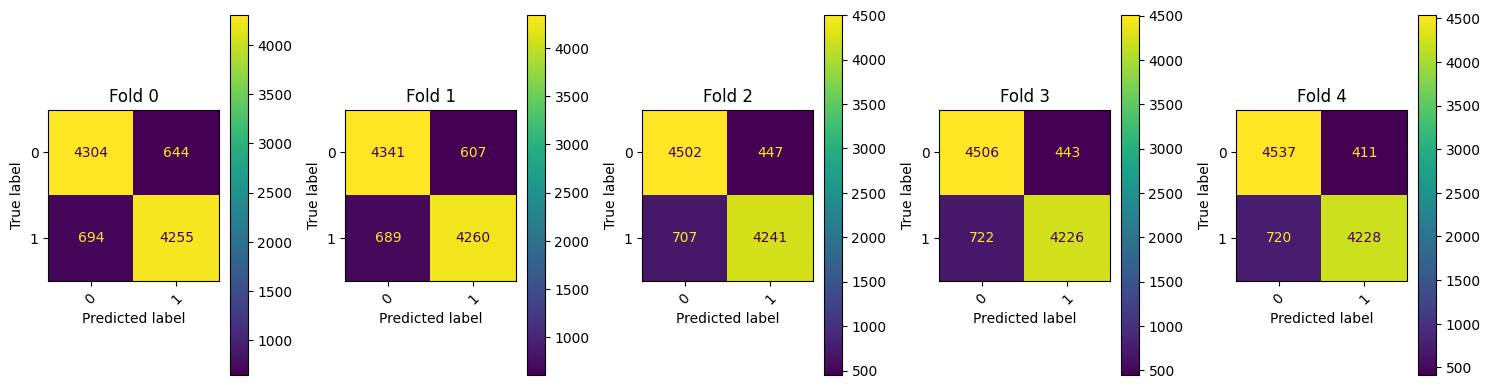

In [11]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
print(f"Decision tree with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=77)

fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []
fold_mcc = []
tree_stats: list[dict[str, float]] = []
hold_out_accuracy = []
hold_out_precision = []
hold_out_recall = []
hold_out_f1 = []
hold_out_mcc = []

fig, ax = plt.subplots(1, NUM_FOLD, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    prec = precision_score(train_y[test_index], y_pred, zero_division=0)
    rec = recall_score(train_y[test_index], y_pred)
    f1 = f1_score(train_y[test_index], y_pred)
    mcc = matthews_corrcoef(train_y[test_index], y_pred)
    max_depth = model.get_depth()
    avg_depth = average_tree_depth(model.tree_)
    n_branches = count_branches(model.tree_)

    fold_accuracy.append(acc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    fold_mcc.append(mcc)
    tree_stats.append(
        {
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "n_branches": n_branches,
        }
    )

    print(
        f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    prec = precision_score(hold_out_test_y, y_hold_out_pred, zero_division=0)
    rec = recall_score(hold_out_test_y, y_hold_out_pred)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred)
    mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    hold_out_precision.append(prec)
    hold_out_recall.append(rec)
    hold_out_f1.append(f1)
    hold_out_mcc.append(mcc)
    print(
        f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_
    )
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

print("\nTree Stats:")
print(
    f"Avg Max Depth: {get_fold_print_string([x['max_depth'] for x in tree_stats])}"
)
print(
    f"Avg Avg Depth: {get_fold_print_string([x['avg_depth'] for x in tree_stats])}"
)
print(
    f"Avg Branches: {get_fold_print_string([x['n_branches'] for x in tree_stats])}"
)

plt.tight_layout()